# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski [2.5 pkt]
4. Jakość kodu [0.5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [ ]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 113
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):

    def __init__(self, input_size: int, output_size: int, init_type: int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        if init_type == 0:
          limit = np.sqrt(6 / (input_size + output_size))
        else:
          limit = np.sqrt(2 / input_size)
        self.weights = np.random.uniform(-limit, limit, (input_size, output_size))
        self.biases = np.zeros((1, output_size))

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.inputs = x
        self.outputs = np.dot(self.inputs, self.weights) + self.biases
        return self.outputs

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        weights_errors = np.dot(self.inputs.T, output_error_derivative)
        biases_errors = np.sum(output_error_derivative, axis=0, keepdims=True)
        self.weights -= self.learning_rate * weights_errors
        self.biases -= self.learning_rate * biases_errors
        return np.dot(output_error_derivative, self.weights.T)

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.inputs = x
        self.outputs = np.tanh(x)
        return self.outputs

    def backward(self, output_error_derivative) -> np.ndarray:
        tanh_derivative = 1 - np.power(self.outputs, 2)
        return output_error_derivative * tanh_derivative

class ReLu(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
      self.inputs = x
      self.outputs = np.maximum(0, x)
      return self.outputs

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
      relu_derivative = np.where(self.inputs > 0, 1, 0)
      return output_error_derivative * relu_derivative

class Sigmoid(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
      self.inputs = x
      self.outputs = 1 / (1 + np.exp(-x))
      return self.outputs

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
      sigmoid_derivative = self.outputs * (1 - self.outputs)
      return output_error_derivative * sigmoid_derivative

class Softmax(Layer):
    def forward(self, x: np.ndarray) -> np.ndarray:
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.outputs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.outputs

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        return output_error_derivative

class Loss:
    def __init__(self, loss_function: callable, loss_function_derivative: callable) -> None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.loss_function(x, y)

    def loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.loss_function_derivative(x, y)

class Network:
    def __init__(self, layers: List[Layer], learning_rate: float) -> None:
        self.layers = layers
        self.learning_rate = learning_rate

    def compile(self, loss: Loss) -> None:
        self.loss = loss

    def __call__(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self,
            x_train: np.ndarray,
            y_train: np.ndarray,
            epochs: int,
            learning_rate: float,
            verbose: int = 0) -> None:
        self.learning_rate = learning_rate
        if verbose > 0 and (epochs % verbose == 0):
          self.losses = [0] * (int(epochs/verbose))
          self.epoch_list = [0] * (int(epochs/verbose))
          i = 0
        if learning_rate is not None:
            for layer in self.layers:
                layer.learning_rate = learning_rate
        for epoch in range(epochs):
            epoch_loss = 0
            output = self(x_train)
            loss_value = self.loss.loss(output, y_train)
            epoch_loss += loss_value
            loss_derivative = self.loss.loss_derivative(output, y_train)
            for layer in reversed(self.layers):
                loss_derivative = layer.backward(loss_derivative)

            predicted_classes = np.argmax(output, axis=1)
            true_classes = np.argmax(y_train, axis=1)
            accuracy = np.mean(predicted_classes == true_classes)

            if verbose > 0 and (epoch + 1) % verbose == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(x_train)}, Accuracy: {accuracy * 100:.2f}%")
                self.losses[i] = epoch_loss / len(x_train)
                self.epoch_list[i] = epoch+1
                i+=1

    def accuracy(self, x_test: np.ndarray, y_test: np.ndarray) -> float:
        predictions = self(x_test)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_test, axis=1)
        accuracy = np.mean(predicted_classes == true_classes)
        return accuracy

def cross_entropy_loss(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    epsilon = 1e-9
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
    return loss

def cross_entropy_loss_derivative(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    m = y_true.shape[0]
    return (y_pred - y_true) / m

In [1]:
def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    x_train = x_train.reshape(-1, 28*28)
    x_test = x_test.reshape(-1, 28*28)

    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test

# Eksperymenty

In [ ]:
x_train, y_train, x_test, y_test = load_mnist_data()

x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

layers = [
  FullyConnected(input_size=784, output_size=128, init_type=0),
  Tanh(),
  FullyConnected(input_size=128, output_size=10, init_type=0),
  Softmax()
]

network = Network(layers, learning_rate=0.01)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)
network.fit(x_train, y_train, epochs=100, learning_rate=0.01, verbose=10)

losses_0 = network.losses.copy()
epochs_0 = network.epoch_list.copy()

accuracy_0 = network.accuracy(x_test, y_test)
print(f"Test Accuracy after training: {accuracy_0 * 100:.2f}%")

Epoch 10/100, Loss: 3.786611505347206e-05, Accuracy: 19.23%
Epoch 20/100, Loss: 3.512091474066087e-05, Accuracy: 29.14%
Epoch 30/100, Loss: 3.272911094335381e-05, Accuracy: 39.22%
Epoch 40/100, Loss: 3.061634191543145e-05, Accuracy: 48.33%
Epoch 50/100, Loss: 2.874259610512505e-05, Accuracy: 55.32%
Epoch 60/100, Loss: 2.7078639145586104e-05, Accuracy: 60.72%
Epoch 70/100, Loss: 2.559940263295275e-05, Accuracy: 64.65%
Epoch 80/100, Loss: 2.4282351019572417e-05, Accuracy: 67.65%
Epoch 90/100, Loss: 2.3107196563781566e-05, Accuracy: 69.94%
Epoch 100/100, Loss: 2.205587818808855e-05, Accuracy: 71.80%
Test Accuracy after training: 72.75%


In [ ]:
x_train, y_train, x_test, y_test = load_mnist_data()

x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

layers = [
  FullyConnected(input_size=784, output_size=128, init_type=0),
  Tanh(),
  FullyConnected(input_size=128, output_size=10, init_type=0),
  Softmax()
]

network = Network(layers, learning_rate=0.1)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)
network.fit(x_train, y_train, epochs=100, learning_rate=0.1, verbose=10)

losses_1 = network.losses.copy()
epochs_1 = network.epoch_list.copy()

accuracy_1 = network.accuracy(x_test, y_test)
print(f"Test Accuracy after training: {accuracy_1 * 100:.2f}%")

Epoch 10/100, Loss: 2.3249080100794996e-05, Accuracy: 70.19%
Epoch 20/100, Loss: 1.6567267684771124e-05, Accuracy: 79.35%
Epoch 30/100, Loss: 1.348930770680243e-05, Accuracy: 82.47%
Epoch 40/100, Loss: 1.173344743173664e-05, Accuracy: 84.06%
Epoch 50/100, Loss: 1.0593343824815754e-05, Accuracy: 85.16%
Epoch 60/100, Loss: 9.788341915473309e-06, Accuracy: 85.90%
Epoch 70/100, Loss: 9.1860457443669e-06, Accuracy: 86.48%
Epoch 80/100, Loss: 8.7160117614125e-06, Accuracy: 86.89%
Epoch 90/100, Loss: 8.337292159428242e-06, Accuracy: 87.36%
Epoch 100/100, Loss: 8.0244237012412e-06, Accuracy: 87.68%
Test Accuracy after training: 88.20%


Epoch 10/100, Loss: 0.00017329794031539707, Accuracy: 10.59%
Epoch 20/100, Loss: 0.00024534247002757124, Accuracy: 11.31%
Epoch 30/100, Loss: 0.0002721029401611938, Accuracy: 20.62%
Epoch 40/100, Loss: 0.00018602110557697037, Accuracy: 19.88%
Epoch 50/100, Loss: 0.00023439664655867053, Accuracy: 20.94%
Epoch 60/100, Loss: 0.00023123826911458311, Accuracy: 20.69%
Epoch 70/100, Loss: 0.00025400931075772833, Accuracy: 20.34%
Epoch 80/100, Loss: 0.0002023057645226794, Accuracy: 20.21%
Epoch 90/100, Loss: 0.00021648717304033924, Accuracy: 19.60%
Epoch 100/100, Loss: 0.00014944332577710844, Accuracy: 26.41%
Test Accuracy after training: 33.01%


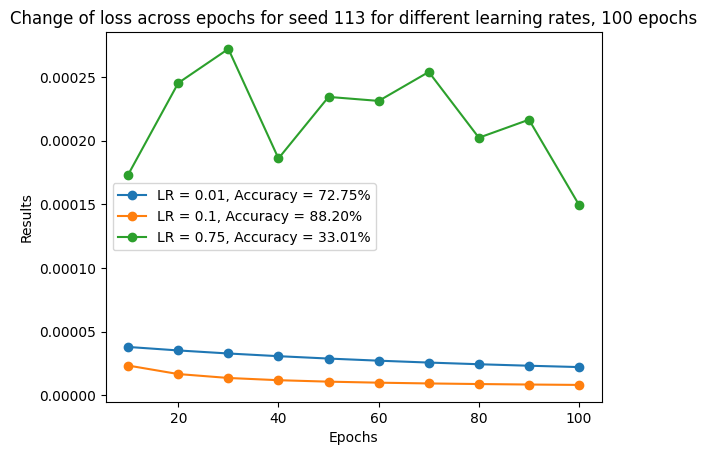

In [ ]:
x_train, y_train, x_test, y_test = load_mnist_data()

x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]


layers = [
  FullyConnected(input_size=784, output_size=128, init_type=0),
  Tanh(),
  FullyConnected(input_size=128, output_size=10, init_type=0),
  Softmax()
]

network = Network(layers, learning_rate=0.75)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)
network.fit(x_train, y_train, epochs=100, learning_rate=0.75, verbose=10)

losses_2 = network.losses.copy()
epochs_2 = network.epoch_list.copy()

accuracy_2 = network.accuracy(x_test, y_test)
print(f"Test Accuracy after training: {accuracy_2 * 100:.2f}%")

plt.plot(epochs_0, losses_0, label = f'LR = 0.01, Accuracy = {accuracy_0 * 100:.2f}%', marker='o')
plt.plot(epochs_1, losses_1, label = f'LR = 0.1, Accuracy = {accuracy_1 * 100:.2f}%', marker='o')
plt.plot(epochs_2, losses_2, label = f'LR = 0.75, Accuracy = {accuracy_2 * 100:.2f}%', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Results")
plt.title(f"Change of loss across epochs for seed {seed} for different learning rates, 100 epochs")
plt.legend()
plt.show()

In [ ]:
"""
x_train, y_train, x_test, y_test = load_mnist_data()

x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

layers = [
  FullyConnected(input_size=784, output_size=128, init_type=0),
  Tanh(),
  FullyConnected(input_size=128, output_size=10, init_type=0),
  Softmax()
]

network = Network(layers, learning_rate=0.1)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)
network.fit(x_train, y_train, epochs=10, learning_rate=0.1, verbose=1)

losses_3 = network.losses.copy()
epochs_3 = network.epoch_list.copy()

accuracy_3 = network.accuracy(x_test, y_test)
print(f"Test Accuracy after training: {accuracy_3 * 100:.2f}%")
"""

'\nx_train, y_train, x_test, y_test = load_mnist_data()\n\nx_train, y_train = x_train[:10000], y_train[:10000]\nx_test, y_test = x_test[:2000], y_test[:2000]\n\nlayers = [\n  FullyConnected(input_size=784, output_size=128, init_type=0),\n  Tanh(),\n  FullyConnected(input_size=128, output_size=10, init_type=0),\n  Softmax()\n]\n\nnetwork = Network(layers, learning_rate=0.1)\nloss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)\nnetwork.compile(loss)\nnetwork.fit(x_train, y_train, epochs=10, learning_rate=0.1, verbose=1)\n\nlosses_3 = network.losses.copy()\nepochs_3 = network.epoch_list.copy()\n\naccuracy_3 = network.accuracy(x_test, y_test)\nprint(f"Test Accuracy after training: {accuracy_3 * 100:.2f}%")\n'

Epoch 10/100, Loss: 1.6837935192311234e-05, Accuracy: 79.65%
Epoch 20/100, Loss: 1.179316051462524e-05, Accuracy: 84.67%
Epoch 30/100, Loss: 9.672344904729168e-06, Accuracy: 86.64%
Epoch 40/100, Loss: 8.45976444631037e-06, Accuracy: 87.77%
Epoch 50/100, Loss: 7.668056988581761e-06, Accuracy: 88.59%
Epoch 60/100, Loss: 7.107723666626261e-06, Accuracy: 89.09%
Epoch 70/100, Loss: 6.687698901209902e-06, Accuracy: 89.58%
Epoch 80/100, Loss: 6.35878106231809e-06, Accuracy: 89.95%
Epoch 90/100, Loss: 6.092214478963422e-06, Accuracy: 90.27%
Epoch 100/100, Loss: 5.870158698347195e-06, Accuracy: 90.53%
Test Accuracy after training: 91.14%


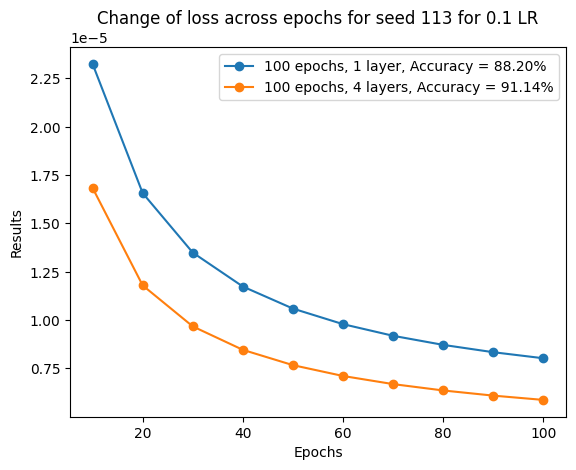

In [ ]:
x_train, y_train, x_test, y_test = load_mnist_data()

x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:2000], y_test[:2000]

layers = [
  FullyConnected(input_size=784, output_size=512, init_type=0),
  Tanh(),
  FullyConnected(input_size=512, output_size=256, init_type=0),
  Tanh(),
  FullyConnected(input_size=256, output_size=128, init_type=0),
  Tanh(),
  FullyConnected(input_size=128, output_size=64, init_type=0),
  Tanh(),
  FullyConnected(input_size=64, output_size=10, init_type=0),
  Softmax()
]

network = Network(layers, learning_rate=0.1)
loss = Loss(cross_entropy_loss, cross_entropy_loss_derivative)
network.compile(loss)
network.fit(x_train, y_train, epochs=100, learning_rate=0.1, verbose=10)

losses_4 = network.losses.copy()
epochs_4 = network.epoch_list.copy()

accuracy_4 = network.accuracy(x_test, y_test)
print(f"Test Accuracy after training: {accuracy_4 * 100:.2f}%")

plt.plot(epochs_1, losses_1, label = f'100 epochs, 1 layer, Accuracy = {accuracy_1 * 100:.2f}%', marker='o')
#plt.plot(epochs_3, losses_3, label = f'10 epochs, 1 layer, Accuracy = {accuracy_3 * 100:.2f}%', marker='o')
plt.plot(epochs_4, losses_4, label = f'100 epochs, 4 layers, Accuracy = {accuracy_4 * 100:.2f}%', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Results")
plt.title(f"Change of loss across epochs for seed {seed} for 0.1 LR")
plt.legend()
plt.show()

# Wnioski

WNIOSKI:
Z wykonanych testów można zauważyć kilka zależności:
- Liczba warstw zwiększa dokładność sieci neuronowej, co można zobaczyć poprzez mniejszy loss. Trzeba jednak uważać by nie było ich zbyt dużo by nie doprowadzić do przetrenowania modelu.
- Zbyt niski learning rate może doprowadzić do mniejszej dokładności (w zależności od innych hiperparametrów), ale zbyt wysoki powoduje, że loss, a razem z nim dokładność sieci neuronowej ciągle oscyluje, co wynika ze zbyt dużej zmiany wag, przez co sieć nie może odnaleźć minimum.
- Za mała niska epok powoduje, że program nie jest w stanie się w pełni nauczyć, co zaniża końcową dokładność sieci kiedy operuje na danych testowych.
- Do najlepszych wyników potrzebny jest cały dataset MNIST, różnica wynosi około 4% dokładności na 6-krotnie mniejszym secie.
- Podsumowując, dla stworzonej przez nas sieci neuronowej, najlepsze wyniki są osiągane przez ok. 100 epok, learning rate = 0.1 oraz 3-4 warstwy.


WYNIKI (dla 10k próbek trenignowych i 2k próbek testowych):

Ziarno 42:

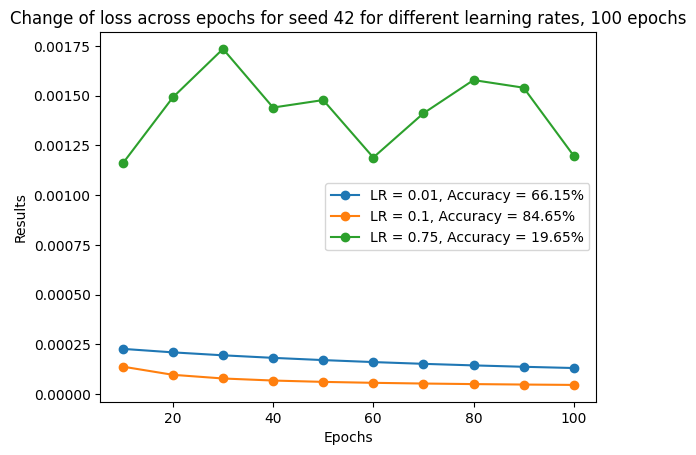

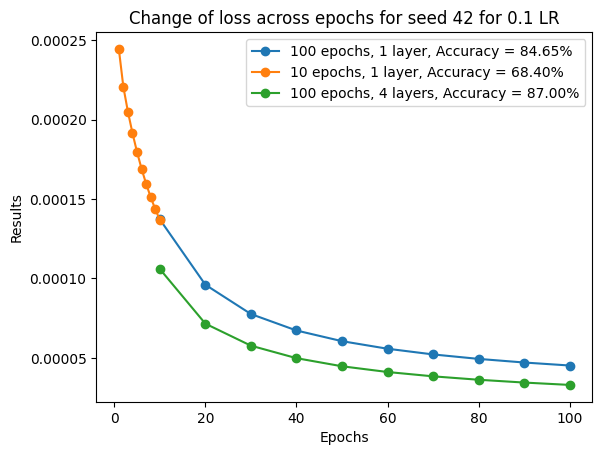

Ziarno 113:

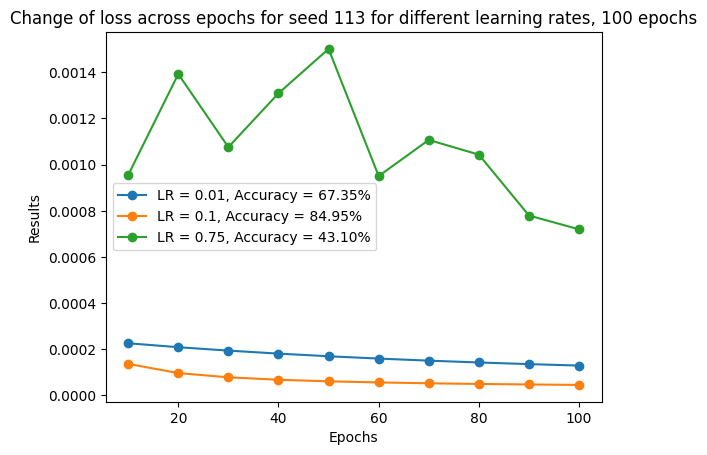

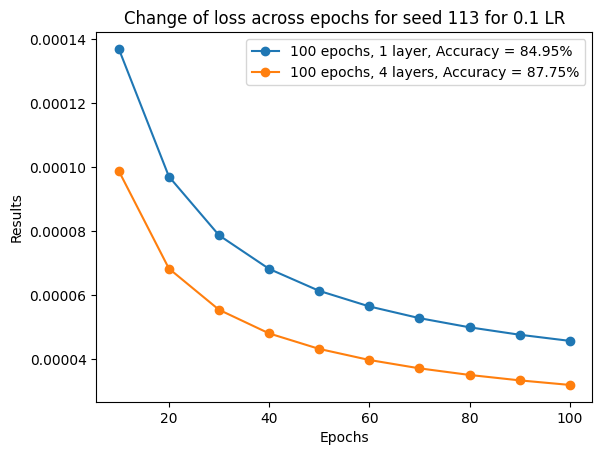

Ziarno 276:

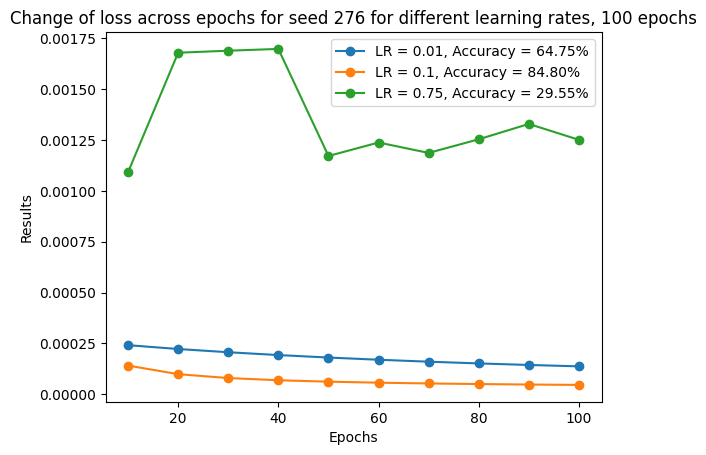

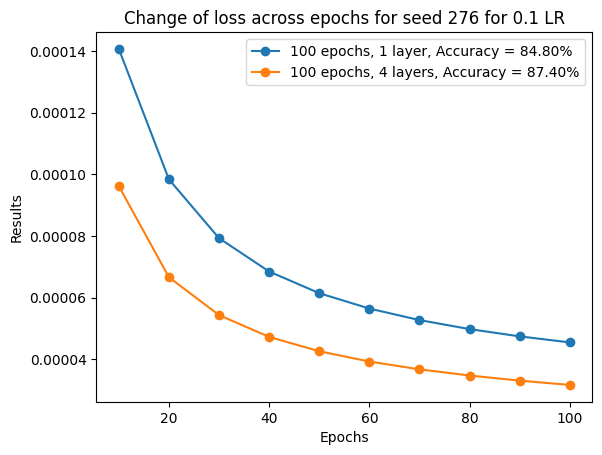

WYNIKI (dla wszystkich 70k próbek):

Ziarno 113:

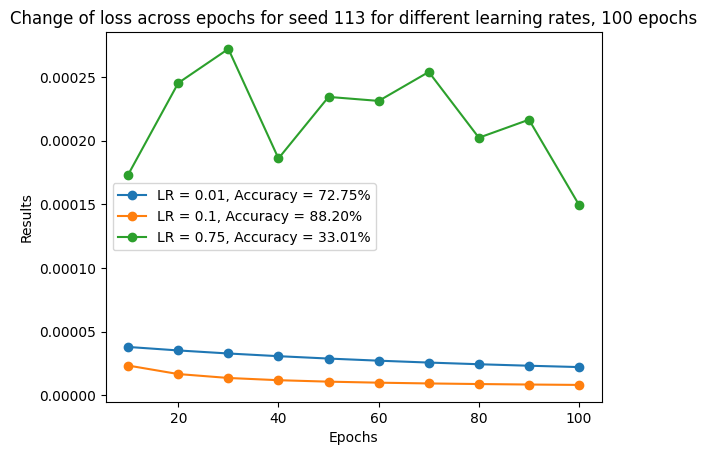

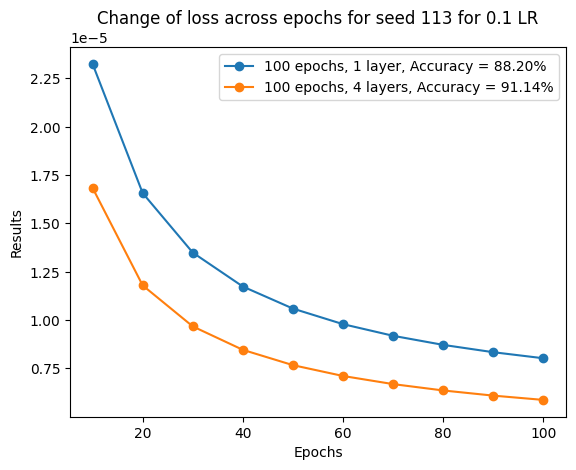